## Module Imports

In [319]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd

from IPython.core.display import HTML
from matplotlib.colors import Normalize
from matplotlib import cm, colors, animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import random as rand
from run_main_pca import pca as cpca, rotation
from scipy import linalg
from scipy.signal import hilbert
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import KernelPCA, PCA, FactorAnalysis, FastICA
from sklearn.manifold import SpectralEmbedding
from utils.rotation import varimax
from utils.utils import double_gamma_hrf, convolve_hrf_events


## Helper Functions

In [311]:
@np.vectorize
def complex_mode(g1, g2, y, t, t_d, w):
    return 2*np.exp(y*t_d)*(np.sin(w*t)*g1 - np.cos(w*t)*g2)


def complex_motion(g1, g2, y, w, n_samples, n_cycles, n_decay_cycles, var, 
                   decay_phase_shift=0):
    """
    Generate (damped) 2-dimensional complex motion between two spatial patterns (g1 and g2). Properties of motion
    are controlled by parameters described below.
    
    Parameters
    ----------
    g1: 2-d numpy array
        spatial pattern 1
    g2: 2-d numpy array
        spatial pattern 2 
    g2_phase_shift: float
        phase shift, in radians, to be applied to g2 pattern
    y : float
        Decay amplitude of complex motion. Decay is sinusoidal, so the complex 
        motion waxes and wanes within a cycle.
    w: float
        angular frequency of sine oscillation. Controls the frequency or speed of the oscillation
    n_samples: int
        number of time samples to generate
    n_cycles: int
        number of full oscillations to cycle through with specified number of time samples (n_samples)
    n_decay_cycles: int
        number of decay cycles to cycle through with specified number of time samples (n_samples)
    var: float
        variance of gaussian noise added to each time point

    Returns:
    list: complex motion spatial pattern at each time point (n_samples)
    """
    g1_vec = g1.flatten()
    g2_vec = g2.flatten()
    x_len, y_len = g1.shape
    t_vec = np.linspace(1,(2*np.pi)*n_cycles, n_samples)
    t_decay_vec = 0.5*np.cos(
        np.linspace(1,(2*np.pi)*n_decay_cycles, n_samples) + decay_phase_shift
    )+0.5
    g_anim = []
    for t, t_d in zip(t_vec, t_decay_vec):
        g_grid = []
        g_grid = complex_mode(g1_vec, g2_vec, y, t, t_d, w)
        grid = np.array(g_grid).reshape(x_len, y_len)
        grid += np.random.normal(0,var,(grid.shape[0], grid.shape[1]))
        g_anim.append(grid)
    return g_anim


def complex_motion_animation(g_anim, fig, ax, vmin=-1, vmax=1):
    """Play animation of complex motion"""
    ims = []
    for g in g_anim:
        im = ax.imshow(g, cmap='coolwarm', vmin=vmin, vmax=vmax)
        ims.append([im])
    anim = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1000)
    return anim


def create_hrf_group(n_ts, activation_indx, ts_len, tr, amplitude, phase_jitter, 
                     amplitude_jitter, ts_sampling=0.01, repeat_n=1):
    """
    n_ts: number of timeseries
    activation_indx = index of activation time point
    ts_len: length of time series
    tr: the sampling rate of the original time series
    amplitude: amplitude of double gamma function 
    phase_offset_window: allowable phase offsets between time series - 
        set as a symmetric window length - sampled from uniform distribution
    ts_sampling: resolution of original time series - default=0.01 Hz
    std_noise: amount of gaussian noise to add to time series - scaling parameter between 0 and 1
    """
    hrf=double_gamma_hrf(60, ts_sampling)
    ts_all = np.zeros((n_ts, ts_len))
    for n in range(n_ts):
        ts = ts_all[n,:]
        indx = rand.randint(activation_indx - phase_jitter, 
                          activation_indx + phase_jitter)
        amp = rand.randint(amplitude - amplitude_jitter, 
                           amplitude + amplitude_jitter)
        ts[indx] = 1
        ts_all[n,:] = (convolve_hrf_events(hrf, ts) * amplitude)
    n_resample=np.int(ts_sampling*ts_len/tr)
    hrf_ts_resample = resample(ts_all, n_resample, axis=1)
    return np.tile(hrf_ts_resample, repeat_n)


def traveling_index(real_vec, imag_vec):
    """
    Compute traveling index as the reciprocal of the condition number between the 
    real and imaginary component from cpca
    """
    return 1/np.linalg.cond(np.vstack((real_vec, imag_vec)).T)


@np.vectorize
def twod_gauss(x, y, var=2):
    """Create two-dimensional gaussian with mean (mu) and variance parameters in the x- and y-plane"""
    return np.exp(-((x - 0)**2 + (y - 0)**2)/(2*(var)**2))



# <b>1. Zero-lag Eigenvalues and Traveling Index at Varying Peak Distance</b>

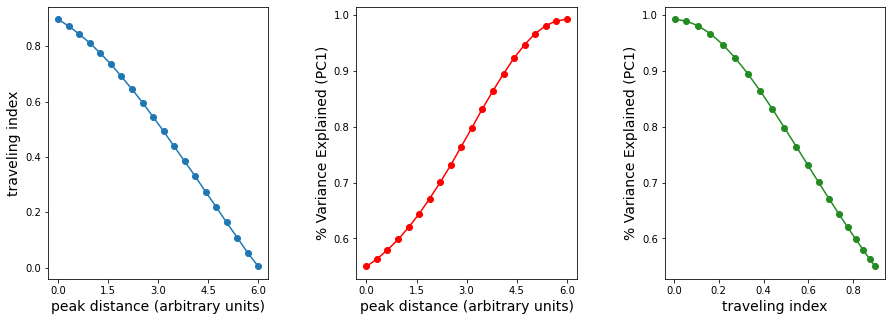

In [266]:
np.random.seed(0) # set random seed for reproducibility
# Create two-dimensional grid
X, Y = np.meshgrid(np.linspace(-3,3,50), np.linspace(-6,6,100))

# Complex Wave parameters
y = -1  # Decay amplitude
w = 1  # angular frequency of sine and cosine - keep at 1 for simplicity
var = 0.05 # variance of gaussian noise added to each time point
n_samples = 400 # Number of samples
n_cycles = 20 # Number of full-cycles
n_decay_cycles = 2 # Number of decay cycles in complex motion

dist_vec = np.linspace(-3,3,20)
var_exp = []
travel_index = []
g_anim_all = []
for d in dist_vec:
    # Create two 2-dimensional gaussian curves on grid
    g1 = twod_gauss(X,Y+d)
    g2 = twod_gauss(X,Y+3)
    g_anim = complex_motion(g1, g2, y, w, n_samples, n_cycles, n_decay_cycles, var)
    # Flatten array to 2d matrix
    g_2d = np.array([g.flatten() for g in g_anim])
    # estimate PCA
    pca = PCA(n_components = 2)
    pca.fit(g_2d)
    evar = pca.explained_variance_ratio_
    var_exp.append(evar[0])
    # estimate CPCA
    g_2d_c = hilbert(g_2d.copy(), axis=0)
    cpca_res = cpca(g_2d_c, 1)
    real_vec = np.real(cpca_res['loadings'][0,:]).T
    imag_vec = np.imag(cpca_res['loadings'][0,:]).T
    travel_index.append(traveling_index(real_vec, imag_vec))

fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].plot(np.round(dist_vec[::-1],2), np.abs(travel_index[::-1]), '-o')
xtick_locs = np.round(np.linspace(-3,3,5),2)
x_tick_labels = np.linspace(0,6,5)
axs[0].set_xticks(xtick_locs)
axs[0].set_xticklabels(x_tick_labels)
axs[0].set_xlabel('peak distance (arbitrary units)', fontsize=14)
axs[0].set_ylabel('traveling index', fontsize=14)
axs[1].plot(np.round(dist_vec[::-1],2), var_exp[::-1], '-o', color='red')
axs[1].set_xticks(xtick_locs)
axs[1].set_xticklabels(x_tick_labels)
axs[1].set_xlabel('peak distance (arbitrary units)', fontsize=14)
axs[1].set_ylabel('% Variance Explained (PC1)', fontsize=14)
axs[2].plot(travel_index, var_exp, '-o', color='forestgreen')
axs[2].set_ylabel('% Variance Explained (PC1)', fontsize=14)
axs[2].set_xlabel('traveling index', fontsize=14)
fig.subplots_adjust(wspace=0.4)

plt.show()

# <b>2 - Simulation of Single Mode Traveling Wave Oscillations</b>

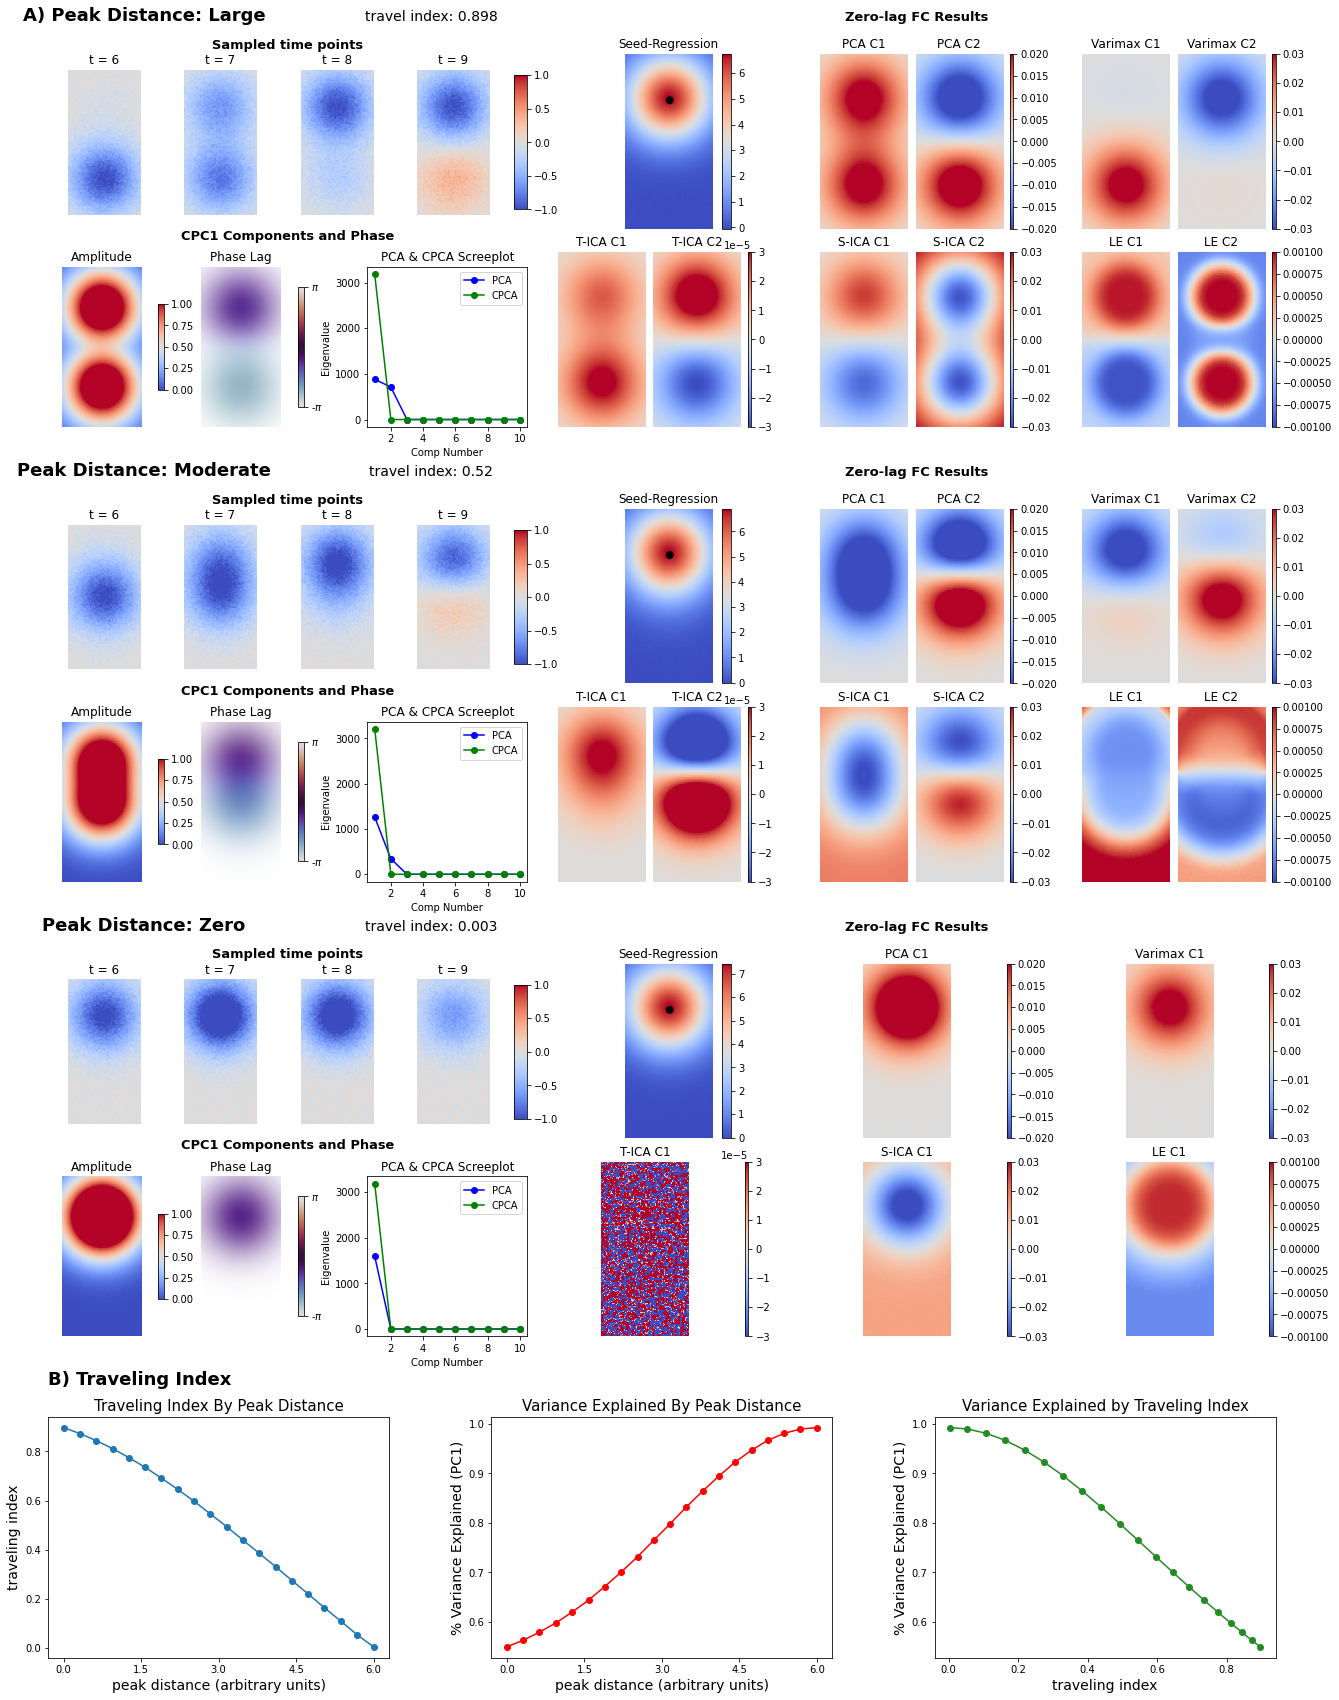

In [339]:
# # np.random.seed(0) # set random seed for reproducibility
# X, Y = np.meshgrid(np.linspace(-3,3,50), np.linspace(-6,6,100))

# # # Complex Wave parameters
# y = -1  # Decay amplitude
# w = 1  # angular frequency of sine and cosine - keep at 1 for simplicity
# var = 0.05 # variance of gaussian noise added to each time point
# n_samples = 800 # Number of samples
# n_cycles = 40 # Number of full-cycles
# n_decay_cycles = 2 # Number of decay cycles in complex motion

# dist = np.linspace(-3,3,5)
# g_anim_all = []
# for d in dist:
#     # Create two 2-dimensional gaussian curves on grid
#     g1 = twod_gauss(X,Y+d)
#     g2 = twod_gauss(X,Y+3)
#     grid_h, grid_w = g1.shape
#     g_anim = complex_motion(g1, g2, y, w, n_samples, n_cycles, n_decay_cycles, var)
#     g_anim_all.append(g_anim)

# evar = []
# evar_c = []
# model_comps = {
#     'pca': [],
#     'varimax': [],
#     's_ica': [],
#     't_ica': [],
#     'le': [],
#     'seed_corr': [],
#     'cpca': [],
#     'c_ica': []
# }

# g_snaps = {}
# for i, g_anim in enumerate(g_anim_all):
#     if i == 0:
#         g_snaps[i] = [g_anim[12], g_anim[14], g_anim[16], g_anim[18]]
#     elif i == 2:
#         g_snaps[i] = [g_anim[12], g_anim[14], g_anim[16], g_anim[18]]
#     elif i == 4:
#         g_snaps[i] = [g_anim[12], g_anim[14], g_anim[16], g_anim[18]]
#     # Flatten array to 2d matrix
#     g_2d = np.array([g.copy().flatten() for g in g_anim])
#     # estimate PCA
#     pca = PCA(n_components = 10)
#     pca.fit(g_2d)
#     evar.append(pca.explained_variance_)
#     model_comps['pca'].append(pca.components_[:2, :])
#     # rotate PCA w/ varimax
#     if i == 5:
#         rotated_weights, _ = varimax(pca.components_[0, :].T)
#     else:
#         rotated_weights, _ = varimax(pca.components_[:2, :].T)
#     model_comps['varimax'].append(rotated_weights.T)
#     # estimate temporal ICA
#     if i == 5:
#         t_ica = FastICA(n_components=1, random_state=0)
#     else:
#         t_ica = FastICA(n_components=2, random_state=0)
#     t_ica.fit(g_2d)
#     model_comps['t_ica'].append(t_ica.components_)
#     # estimate spatial ICA
#     if i == 5:
#         s_ica = FastICA(n_components=1, random_state=0)
#     else:
#         s_ica = FastICA(n_components=2, random_state=0)
#     s_sources = s_ica.fit_transform(g_2d.T)
#     model_comps['s_ica'].append(s_sources.T)
#     # estimate Laplacian Eigenmaps
#     le = SpectralEmbedding(random_state=0)
#     le.fit(g_2d.T)
#     model_comps['le'].append(le.embedding_.T)
#     # Estimate seed-based correlation
#     x,y = (0, 2)
#     seed_ts = np.array([g_snap[x,y] for g_snap in g_anim]).reshape(-1,1)
#     reg = LinearRegression()
#     reg.fit(seed_ts, g_2d)
#     model_comps['seed_corr'].append(reg.coef_)
#     # Estimate Complex PCA
#     g_2d_c = hilbert(g_2d.copy(), axis=0)
#     cpca_res = cpca(g_2d_c.conj(), 10)
#     model_comps['cpca'].append(cpca_res['loadings'][:2,:])
#     evar_c.append(cpca_res['exp_var'])

fig = plt.figure(figsize=(22,30), constrained_layout=False)

# 4 by 2 overall grid for plotting
gspec = fig.add_gridspec(4,2, hspace=0.15, wspace=0.05, 
                         width_ratios=[0.4,0.6], 
                         height_ratios=[0.3, 0.3, 0.3, 0.2])
# Figure title
# sup_title_ax = fig.add_subplot(gspec[0,0])
# sup_title_ax.set_title('Simulation', fontsize=16, fontweight='bold')
# sup_title_ax.axis('off')

# Plot snapshots, cpca and scree plots of three simulations (diff phase lags) - one subgrid for title, 
# the other for plots
snaps = [6,7,8,9]
phase_lag = [r'A) Peak Distance: Large', r'Peak Distance: Moderate', r'Peak Distance: Zero']
phase_indx = [0,2,4]
for i, (indx, lag_title, p_indx) in enumerate(zip(snaps, phase_lag, phase_indx)):
    g_sub = gridspec.GridSpecFromSubplotSpec(4,1, subplot_spec=gspec[i,0], 
                                             wspace=0.1, hspace=0.3, 
                                             height_ratios=[0.01,0.49, 0.01, 0.49])
    # Insert title for simulation
    g_sub_0 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=g_sub[0], 
                                             wspace=0.5)
    title_ax = fig.add_subplot(g_sub_0[0])
    title_ax.set_title(lag_title,
                       fontsize=18, fontweight='bold')
    title_ax.axis('off')
    
    
    # Calculate and display traveling index
    real_vec = np.real(model_comps['cpca'][p_indx][0,:]).T
    imag_vec = np.imag(model_comps['cpca'][p_indx][0,:]).T
    t_index = traveling_index(real_vec, imag_vec)
    index_ax = fig.add_subplot(g_sub_0[1])
    index_ax.set_title(f'travel index: {round(t_index,3)}',
                       fontsize=14)
    index_ax.axis('off')
    
    # We create a horizontal grid with fives axes, the fifth axis is for the colorbar. 
    g_sub_0 = gridspec.GridSpecFromSubplotSpec(2,5, subplot_spec=g_sub[1], 
                                               wspace=0.05, 
                                               width_ratios=[0.25,0.25,0.25,0.25,0.03],
                                               height_ratios = [0.05, 0.95],
                                               hspace=0.1)
    # Insert title for simulation snapshots
    title_ax = fig.add_subplot(g_sub_0[0, :])
    title_ax.set_title('Sampled time points',
                       fontsize=13, fontweight='bold')
    title_ax.axis('off')
    
    # Plot simulation snapshots
    for i_snap, snap in enumerate(snaps):
        ax = fig.add_subplot(g_sub_0[1,i_snap])
        im = ax.imshow(g_snaps[p_indx][i_snap], cmap='coolwarm', vmin=-1, vmax=1)
        ax.set_title(f't = {snap}')
        ax.axis('off')

    ax = fig.add_subplot(g_sub_0[1,4])
    ax.set_aspect(10)
    plt.colorbar(im,cax=ax)
    
    # Plot cpca results
    
    title_ax = fig.add_subplot(g_sub[2])
    title_ax.set_title('CPC1 Components and Phase', y=-1,
                       fontsize=13, fontweight='bold')
    title_ax.axis('off')
    # Separate sub-grids for CPCA component amplitude weights, component phase and scree plot
    g_sub_0 = gridspec.GridSpecFromSubplotSpec(1,3, subplot_spec=g_sub[3], 
                                               wspace=0.3, 
                                               width_ratios=[0.3, 0.3, 0.4],
                                               hspace=0)
    # Amplitude spatial weights sub-grid
    g_sub_00 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=g_sub_0[0], 
                                               wspace=0.1, 
                                               width_ratios=[0.95,0.05],
                                               hspace=0)
    # Plot amplitude of CPCA comp
    amp_map = np.abs(model_comps['cpca'][p_indx][0,:]).reshape(grid_h, grid_w)
    ax = fig.add_subplot(g_sub_00[0])
    im = ax.imshow(amp_map, cmap='coolwarm', vmin=0, vmax=1)  # arbitrary sign-flip
    ax.set_title('Amplitude')
    ax.axis('off')
    # Plot colorbar
    ax = fig.add_subplot(g_sub_00[1])
    ax.set_aspect(15)
    plt.colorbar(im, cax=ax)
    # Move colorbar closer to figure
    pos = ax.get_position()
    pos.x0 = pos.x0 - 0.005
    ax.set_position(pos)
    
    # Phase map sub-grid
    g_sub_00 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=g_sub_0[1], 
                                               wspace=0, 
                                               width_ratios=[0.95, 0.05],
                                               hspace=0)
    # Plot phase of CPCA comp, transparency set by cpca comp amplitude
    phase_map = np.angle(model_comps['cpca'][p_indx][0,:]).reshape(grid_h, grid_w)
    norm = Normalize(-np.pi, np.pi)
    img_array = plt.get_cmap('twilight')(norm(phase_map))
    img_array[..., 3] = (amp_map/amp_map.max())  # <- set transparency by amplitude
    ax = fig.add_subplot(g_sub_00[0])
    im = ax.imshow(img_array, cmap='twilight', vmin=0, vmax=1)
    ax.set_title('Phase Lag')
    ax.axis('off')
    # Move to the left
    pos = ax.get_position()
    pos.x0 = pos.x0 - 0.03
    ax.set_position(pos)
     # Plot phase colorbar
    ax = fig.add_subplot(g_sub_00[1])
    ax.set_aspect(20)
    cbar = plt.colorbar(im,cax=ax, ticks=[0,1])
    cbar.ax.set_yticklabels([r'-$\pi$', r'$\pi$']) 
    # Move colorbar closer to figure
    pos = ax.get_position()
    pos.x0 = pos.x0 - 0.03
    ax.set_position(pos)
    
    # Plot screeplot of PCA and CPCA
    ax = fig.add_subplot(g_sub_0[2])
    ax.set_title('PCA & CPCA Screeplot')
    ax.plot(list(range(1,11)), evar[p_indx], '-o', color='blue', label='PCA')
    ax.plot(list(range(1,11)), evar_c[p_indx], '-o', color='green', label='CPCA')
    ax.set_xlabel('Comp Number')
    ax.set_ylabel('Eigenvalue')
    ax.legend()


for i, p_indx in enumerate(phase_indx):
    g_sub = gridspec.GridSpecFromSubplotSpec(3,3, subplot_spec=gspec[i,1], 
                                             wspace=0.35, height_ratios=[0.01,0.5,0.5], 
                                             hspace=0.2)
    # Plot section title
    title_ax = fig.add_subplot(g_sub[0,:])
    title_ax.set_title('Zero-lag FC Results', y=1,
                       fontsize=13, fontweight='bold')
    title_ax.axis('off')
    
    # Seed-based Correlation
    ax = fig.add_subplot(g_sub[1,0])
    im = ax.imshow(model_comps['seed_corr'][p_indx].reshape(grid_h, grid_w), cmap='coolwarm')
    # Plot approximate seed location as black circle
    circle = plt.Circle((25, 26), 2, color='k')
    ax.add_patch(circle)
    ax.set_title('Seed-Regression')
    ax.axis('off')
    plt.colorbar(im)
    # PCA
    if i == 2:
        g_sub_0 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=g_sub[1,1], 
                                               wspace=0.1, width_ratios=[0.95,0.05])
        # Plot first pca comp
        ax = fig.add_subplot(g_sub_0[0])
        im = ax.imshow(model_comps['pca'][p_indx][0,:].reshape(grid_h, grid_w), cmap='coolwarm', 
                       vmin=-.02, vmax=0.02)
        ax.set_title('PCA C1')
        ax.axis('off')
        # Plot colorbar
        ax = fig.add_subplot(g_sub_0[1])
        ax.set_aspect(50)
        plt.colorbar(im, cax=ax)
        
    else:
        g_sub_0 = gridspec.GridSpecFromSubplotSpec(1,3, subplot_spec=g_sub[1,1], 
                                                   wspace=0.1, width_ratios=[0.49,0.49,0.02])
        # Plot first pca comp
        ax = fig.add_subplot(g_sub_0[0])
        im = ax.imshow(model_comps['pca'][p_indx][0,:].reshape(grid_h, grid_w), cmap='coolwarm', 
                       vmin=-.02, vmax=0.02)
        ax.set_title('PCA C1')
        ax.axis('off')
        # Plot second pca comp
        ax = fig.add_subplot(g_sub_0[1])
        im = ax.imshow(model_comps['pca'][p_indx][1,:].reshape(grid_h, grid_w), cmap='coolwarm', 
                       vmin=-.02, vmax=0.02)
        ax.set_title('PCA C2')
        ax.axis('off')
        # Plot colorbar
        ax = fig.add_subplot(g_sub_0[2])
        ax.set_aspect(50)
        plt.colorbar(im, cax=ax)
    # PCA - Varimax Rotation
    if i == 2:
        g_sub_0 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=g_sub[1,2], 
                                                   wspace=0.1, width_ratios=[0.95, 0.05])
        # Plot first varimax comp
        ax = fig.add_subplot(g_sub_0[0])
        im = ax.imshow(model_comps['varimax'][p_indx][0,:].reshape(grid_h, grid_w), cmap='coolwarm', 
                       vmin=-.03, vmax=0.03)
        ax.set_title('Varimax C1')
        ax.axis('off')
        # Plot colorbar
        ax = fig.add_subplot(g_sub_0[1])
        ax.set_aspect(50)
        plt.colorbar(im, cax=ax)
    else:
        g_sub_0 = gridspec.GridSpecFromSubplotSpec(1,3, subplot_spec=g_sub[1,2], 
                                                   wspace=0.1, width_ratios=[0.49,0.49,0.02])
        # Plot first varimax comp
        ax = fig.add_subplot(g_sub_0[0])
        im = ax.imshow(model_comps['varimax'][p_indx][0,:].reshape(grid_h, grid_w), cmap='coolwarm', 
                       vmin=-.03, vmax=0.03)
        ax.set_title('Varimax C1')
        ax.axis('off')
        # Plot second varimax comp
        ax = fig.add_subplot(g_sub_0[1])
        im = ax.imshow(model_comps['varimax'][p_indx][1,:].reshape(grid_h, grid_w), cmap='coolwarm', 
                       vmin=-.03, vmax=0.03)
        ax.set_title('Varimax C2')
        ax.axis('off')
        # Plot colorbar
        ax = fig.add_subplot(g_sub_0[2])
        ax.set_aspect(50)
        plt.colorbar(im, cax=ax)
    # Temporal ICA
    if i == 2:
        g_sub_0 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=g_sub[2,0], 
                                                   wspace=0.1, width_ratios=[0.95, 0.05])
        # Plot first t-ica comp
        ax = fig.add_subplot(g_sub_0[0])
        im = ax.imshow(model_comps['t_ica'][p_indx][0,:].reshape(grid_h, grid_w), cmap='coolwarm', 
                       vmin=-0.00003, vmax=0.00003)
        ax.set_title('T-ICA C1')
        ax.axis('off')
        # Plot colorbar
        ax = fig.add_subplot(g_sub_0[1])
        ax.set_aspect(50)
        plt.colorbar(im, cax=ax)
    else:
        g_sub_0 = gridspec.GridSpecFromSubplotSpec(1,3, subplot_spec=g_sub[2,0], 
                                                   wspace=0.1, width_ratios=[0.49,0.49, 0.02])
        # Plot first t-ica comp
        ax = fig.add_subplot(g_sub_0[0])
        im = ax.imshow(model_comps['t_ica'][p_indx][0,:].reshape(grid_h, grid_w), cmap='coolwarm', 
                       vmin=-0.00003, vmax=0.00003)
        ax.set_title('T-ICA C1')
        ax.axis('off')
        # Plot second t-ica comp
        ax = fig.add_subplot(g_sub_0[1])
        im = ax.imshow(model_comps['t_ica'][p_indx][1,:].reshape(grid_h, grid_w), cmap='coolwarm', 
                       vmin=-0.00003, vmax=0.00003)
        ax.set_title('T-ICA C2')
        ax.axis('off')
        # Plot colorbar
        ax = fig.add_subplot(g_sub_0[2])
        ax.set_aspect(50)
        plt.colorbar(im, cax=ax)
    # Spatial ICA
    if i == 2:
        g_sub_0 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=g_sub[2,1], 
                                                   wspace=0.1, width_ratios=[0.95,0.05])
        ax = fig.add_subplot(g_sub_0[0])
        im = ax.imshow(model_comps['s_ica'][p_indx][0,:].reshape(grid_h, grid_w), cmap='coolwarm', 
                       vmin=-0.03, vmax=0.03)
        # Plot first ica comp
        ax.set_title('S-ICA C1')
        ax.axis('off')
        # Plot colorbar
        ax = fig.add_subplot(g_sub_0[1])
        ax.set_aspect(50)
        plt.colorbar(im, cax=ax)
    else:
        g_sub_0 = gridspec.GridSpecFromSubplotSpec(1,3, subplot_spec=g_sub[2,1], 
                                                   wspace=0.1, width_ratios=[0.49,0.49, 0.02])
        # Plot first ica comp
        ax = fig.add_subplot(g_sub_0[0])
        im = ax.imshow(model_comps['s_ica'][p_indx][0,:].reshape(grid_h, grid_w), cmap='coolwarm', 
                       vmin=-0.03, vmax=0.03)
        ax.set_title('S-ICA C1')
        ax.axis('off')
        # Plot second ica comp
        ax = fig.add_subplot(g_sub_0[1])
        im = ax.imshow(model_comps['s_ica'][p_indx][1,:].reshape(grid_h, grid_w), cmap='coolwarm',
                       vmin=-0.03, vmax=0.03)
        ax.set_title('S-ICA C2')
        ax.axis('off')
        # Plot colorbar
        ax = fig.add_subplot(g_sub_0[2])
        ax.set_aspect(50)
        plt.colorbar(im, cax=ax)
    # Laplacian Eigenmaps
    if i == 2:
        g_sub_0 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=g_sub[2,2], 
                                                   wspace=0.1, width_ratios=[0.95, 0.05])
        # Plot first le comp
        ax = fig.add_subplot(g_sub_0[0])
        im = ax.imshow(model_comps['le'][p_indx][0,:].reshape(grid_h, grid_w), cmap='coolwarm', 
                       vmin=-0.001, vmax=0.001)
        ax.set_title('LE C1')
        ax.axis('off')
        # Plot colorbar
        ax = fig.add_subplot(g_sub_0[1])
        ax.set_aspect(50)
        plt.colorbar(im, cax=ax)
    else:
        g_sub_0 = gridspec.GridSpecFromSubplotSpec(1,3, subplot_spec=g_sub[2,2], 
                                                   wspace=0.1, width_ratios=[0.49,0.49, 0.02])
        # Plot first le comp
        ax = fig.add_subplot(g_sub_0[0])
        im = ax.imshow(model_comps['le'][p_indx][0,:].reshape(grid_h, grid_w), cmap='coolwarm', 
                       vmin=-0.001, vmax=0.001)
        ax.set_title('LE C1')
        ax.axis('off')
        # Plot second le comp
        ax = fig.add_subplot(g_sub_0[1])
        im = ax.imshow(model_comps['le'][p_indx][1,:].reshape(grid_h, grid_w), cmap='coolwarm',
                      vmin=-0.001, vmax=0.001)
        ax.set_title('LE C2')
        ax.axis('off')
        # Plot colorbar
        ax = fig.add_subplot(g_sub_0[2])
        ax.set_aspect(50)
        plt.colorbar(im, cax=ax)

# Plot traveling wave index by second-to-eigenvalue ratio
g_sub = gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gspec[3,:], hspace=0.1, 
                                         wspace=0.1, height_ratios=[0.05,0.95])
# Insert title
title_ax = fig.add_subplot(g_sub[0])
title_ax.set_title('B) Traveling Index',
                   fontsize=18, fontweight='bold', loc='left')
title_ax.axis('off')

# Plot lineplots
g_sub0 = gridspec.GridSpecFromSubplotSpec(1,3, subplot_spec=g_sub[1], wspace=0.3)
# Plot traveling index by phase lag
ax = fig.add_subplot(g_sub0[0])
ax.set_title('Traveling Index By Peak Distance', fontsize=15)
ax.plot(np.round(dist_vec[::-1],2), np.abs(travel_index[::-1]), '-o')
xtick_locs = np.round(np.linspace(-3,3,5),2)
x_tick_labels = np.linspace(0,6,5)
ax.set_xticks(xtick_locs)
ax.set_xticklabels(x_tick_labels)
ax.set_xlabel('peak distance (arbitrary units)', fontsize=14)
ax.set_ylabel('traveling index', fontsize=14)
# Plot second-to-first eigen ratio by phase lag
ax = fig.add_subplot(g_sub0[1])
ax.set_title('Variance Explained By Peak Distance', fontsize=15)
ax.plot(np.round(dist_vec[::-1],2), var_exp[::-1], '-o', color='red')
ax.set_xticks(xtick_locs)
ax.set_xticklabels(x_tick_labels)
ax.set_xlabel('peak distance (arbitrary units)', fontsize=14)
ax.set_ylabel('% Variance Explained (PC1)', fontsize=14)
# Plot second-to-first eigen ratio by traveling index
ax = fig.add_subplot(g_sub0[2])
ax.set_title('Variance Explained by Traveling Index', fontsize=15)
ax.plot(travel_index, var_exp, '-o', color='forestgreen')
ax.set_xlabel('traveling index', fontsize=14)
ax.set_ylabel('% Variance Explained (PC1)', fontsize=14)

plt.savefig('results/figures/simulation_main.png', bbox_inches='tight')
plt.show()

# <b>3 - Simulation of Two Mode Traveling Wave Oscillations</b>

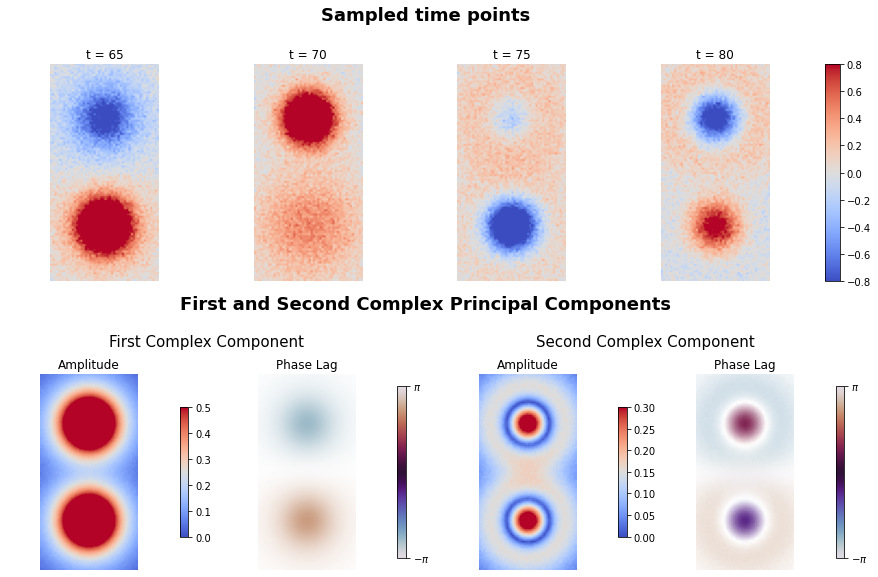

In [323]:
np.random.seed(0) # set random seed for reproducibility

# Create two 2-dimensional gaussian curves on grid
X, Y = np.meshgrid(np.linspace(-3,3,50), np.linspace(-6,6,100))

g1 = twod_gauss(X,Y-3)*0.5
g2 = twod_gauss(X,Y+3)*0.5
g3 = twod_gauss(X,Y-3, var=1)
g4 = twod_gauss(X,Y+3, var=1)
grid_h, grid_w = g1.shape
y = -2
w_1 = 1 # angular frequency of mode 1
w_2 = 2 # angular frequency of mode 2
var = 0.05
# Create two traveling wave oscillations - mode 1 and 2
# Low frequency, large gaussian oscillation - mode 1
g_anim1 = complex_motion(g1, g2, y, w_1, 1000, 30, n_decay_cycles, var)
# High frequency, small gaussian oscillation - mode 2
g_anim2 = complex_motion(g3, g4, y, w_2, 1000, 30, n_decay_cycles, var, 
                         decay_phase_shift=np.pi/2)
# Linear sum of two modes
g_anim_sum = [ga1 + ga2 for ga1, ga2 in zip(g_anim1, g_anim2)]

# Flatten array to 2d matrix
g_2d = np.array([g.flatten() for g in g_anim_sum])
# Estimate Complex PCA
g_2d_c = hilbert(g_2d.copy(), axis=0)
cpca_res = cpca(g_2d_c.conj(), 10)


fig = plt.figure(figsize=(15,10), constrained_layout=False)

# 2 by 1 overall grid for plotting
gspec = fig.add_gridspec(4,1, hspace=0.3, wspace=0.05, height_ratios=[0.01,0.5,0.01,0.5])

# Plot section titles
title_ax = fig.add_subplot(gspec[0])
title_ax.set_title('Sampled time points',
                   fontsize=18, fontweight='bold')
title_ax.axis('off')

title_ax = fig.add_subplot(gspec[2])
title_ax.set_title('First and Second Complex Principal Components',
                   fontsize=18, fontweight='bold')
title_ax.axis('off')


# Snapshots of simulation
snaps = [65, 70, 75, 80]
g_sub = gridspec.GridSpecFromSubplotSpec(1,5, subplot_spec=gspec[1], 
                                         wspace=0.05, 
                                         width_ratios=[0.25,0.25,0.25,0.25,0.03])
# Plot simulation snapshots
for i_snap, snap in enumerate(snaps):
    ax = fig.add_subplot(g_sub[i_snap])
    im = ax.imshow(g_anim_sum[snap], cmap='coolwarm', vmin=-0.8, vmax=0.8)
    ax.set_title(f't = {snap}')
    ax.axis('off')

# Plot colorbar
ax = fig.add_subplot(g_sub[4])
ax.set_aspect(15)
plt.colorbar(im,cax=ax)

## Plot analysis results
g_sub = gridspec.GridSpecFromSubplotSpec(2,2, subplot_spec=gspec[3], 
                                         wspace=0.1, width_ratios=[0.5,0.5], 
                                         height_ratios = (0.01,0.99))
# Plot CPCA Comp Titles
title_ax = fig.add_subplot(g_sub[0,0])
title_ax.set_title('First Complex Component',
                   fontsize=15)
title_ax.axis('off')

title_ax = fig.add_subplot(g_sub[0,1])
title_ax.set_title('Second Complex Component',
                   fontsize=15)
title_ax.axis('off')

# Loop through first and second component
for i in [0,1]:
    # Separate sub-grids for CPCA component amplitude weights, component phase
    g_sub_0 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=g_sub[1,i], 
                                               wspace=0.2, 
                                               width_ratios=[0.5, 0.5],
                                               hspace=0)
    # Amplitude spatial weights sub-grid
    g_sub_00 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=g_sub_0[0], 
                                               wspace=0.1, 
                                               width_ratios=[0.95,0.05],
                                               hspace=0)
    # Plot amplitude of component
    if i == 0:
        vmin, vmax = (0,0.5)
    else:
        vmin, vmax = (0,0.3)

    amp_map = np.abs(cpca_res['loadings'][i,:]).reshape(grid_h, grid_w)
    ax = fig.add_subplot(g_sub_00[0])
    im = ax.imshow(amp_map, cmap='coolwarm', vmin=vmin, vmax=vmax)  
    ax.set_title('Amplitude')
    ax.axis('off')
    # Plot colorbar
    ax = fig.add_subplot(g_sub_00[1])
    ax.set_aspect(15)
    plt.colorbar(im, cax=ax)

    # Phase map sub-grid
    g_sub_00 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=g_sub_0[1], 
                                                wspace=0.1, 
                                                width_ratios=[0.95, 0.05],
                                                hspace=0)
    # Plot phase of CPCA comp, transparency set by cpca comp amplitude
    phase_map = np.angle(cpca_res['loadings'][i,:]).reshape(grid_h, grid_w)
    norm = Normalize(-np.pi, np.pi)
    img_array = plt.get_cmap('twilight')(norm(phase_map))
    img_array[..., 3] = (amp_map/amp_map.max())  # <- set transparency by amplitude
    ax = fig.add_subplot(g_sub_00[0])
    im = ax.imshow(img_array, cmap='twilight', vmin=0, vmax=1)
    ax.set_title('Phase Lag')
    ax.axis('off')
    # Plot phase colorbar
    ax = fig.add_subplot(g_sub_00[1])
    ax.set_aspect(20)
    cbar = plt.colorbar(im,cax=ax, ticks=[0,1])
    cbar.ax.set_yticklabels([r'$-\pi$', r'$\pi$']) 

plt.savefig('results/figures/simulation_twomode.png', bbox_inches='tight')
plt.show()


# <b> 3. Simulation of Traveling Wave Hemodynamic Signals</b>

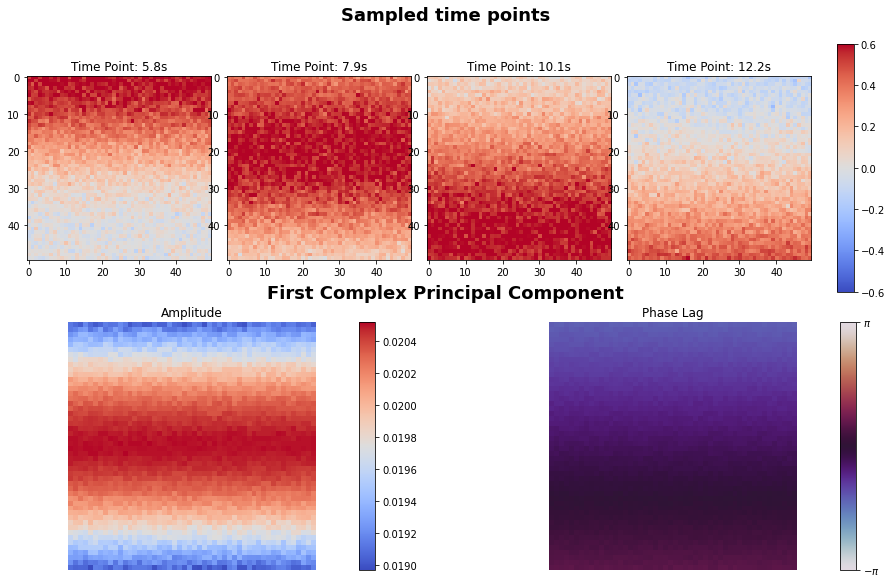

In [338]:
# Simulation parameters
std_noise = 0.05; # noise-to-signal ratio
tr = 0.72
n_per_shift = 50
ts_len = 2000  
phase_jitter=10
amplitude_jitter=0.5
phase_shift = 10
start = 50
ts_sampling=0.01
n_repeats=500
n_resample = np.int(ts_len*ts_sampling/tr)*n_repeats

# Create simulation
travel_region = range(50)
all_ts = np.zeros((50,50,n_resample))

indx = 0
for i, n in enumerate(travel_region):
    all_ts[indx,:,:] = create_hrf_group(n_per_shift, start, ts_len, tr, 1, phase_jitter, amplitude_jitter, ts_sampling, n_repeats)
    all_ts[indx,:,:] += np.array([std_noise*rand.randn(all_ts.shape[2]) for n in range(n_per_shift)])
    start += phase_shift
    indx += 1

# Convert to 2d matrix
all_ts_2d = [(all_ts[i,j,:], (i,j)) for i in range(all_ts.shape[0]) for j in range(all_ts.shape[1])]
mat_2d = np.array([ts[0] for ts in all_ts_2d]).T

# Compute CPCA
mat_2d_c = hilbert(zscore(mat_2d), axis=0)
pca_res = cpca(mat_2d_c.conj(), 1)
amp_map = np.abs(pca_res['Va'])
phase_map = np.angle(pca_res['Va']*-1) # rotate by 90 degrees for viz purposes


fig = plt.figure(figsize=(15,10), constrained_layout=False)

# 2 by 1 overall grid for plotting
gspec = fig.add_gridspec(4,1, hspace=0.1, wspace=0.05, 
                         height_ratios=[0.01,0.49,0.01,0.49])
# Set section titles
title_ax = fig.add_subplot(gspec[0])
title_ax.set_title('Sampled time points', fontsize=18, fontweight='bold')
title_ax.axis('off')

title_ax = fig.add_subplot(gspec[2])
title_ax.set_title('First Complex Principal Component', fontsize=18, fontweight='bold')
title_ax.axis('off')

# Plot sampled time points
g_sub = gridspec.GridSpecFromSubplotSpec(1,5, subplot_spec=gspec[1], 
                                         wspace=0.1, 
                                         width_ratios=[0.25, 0.25, 0.25, 0.25, 0.05],
                                         hspace=0)
for i, indx in enumerate([7,10,13,16]):
    ax = fig.add_subplot(g_sub[i])
    im = ax.imshow(all_ts[:,:,indx], cmap='coolwarm', vmin=-0.6, vmax=0.6)
    ax.set_title(f'Time Point: {round((indx+1)*tr,1)}s')

# Plot colorbar
ax = fig.add_subplot(g_sub[4])
ax.set_aspect(15)
plt.colorbar(im, cax=ax)

# Separate sub-grids for CPCA component amplitude weights, component phase
g_sub = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gspec[3], 
                                         wspace=0.4, 
                                         width_ratios=[0.5, 0.5],
                                         hspace=0)
# Amplitude spatial weights sub-grid
g_sub_0 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=g_sub[0], 
                                           wspace=0.01, 
                                           width_ratios=[0.95,0.05],
                                           hspace=0)

ax = fig.add_subplot(g_sub_0[0])
im = ax.imshow(amp_map.reshape(50,50), cmap='coolwarm')  
ax.set_title('Amplitude')
ax.axis('off')
# Plot colorbar
ax = fig.add_subplot(g_sub_0[1])
ax.set_aspect(15)
plt.colorbar(im, cax=ax)

# Phase map sub-grid
g_sub_1 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=g_sub[1], 
                                           wspace=0.01, 
                                           width_ratios=[0.5, 0.05],
                                           hspace=0)
ax = fig.add_subplot(g_sub_1[0])
im = ax.imshow(phase_map.reshape(50,50), cmap='twilight', vmin=-np.pi, vmax=np.pi)  
ax.set_title('Phase Lag')
ax.axis('off')
# Plot colorbar
ax = fig.add_subplot(g_sub_1[1])
ax.set_aspect(15)
cbar = plt.colorbar(im,cax=ax, ticks=[-np.pi, np.pi])
cbar.ax.set_yticklabels([r'$-\pi$', r'$\pi$']) 

plt.savefig('results/figures/supplementaryC_simulation.png')
plt.show()


### Figure Caption

Global BOLD Propagation Simulation. The first ~25 sec of an artificially constructed BOLD propagation simulation. Artificial ‘vertices’ are arranged along a 50-by-50 spatial grid. Vertex time series are created by convolving simple impulse time series with the canonical hemodynamic response function. The time-series of each vertex in the grid are time-lagged such that vertex time series in the upper part of the grid peak first, while those in the bottom part peak last. As observed from the first ~25 sec snapshots of the spatial grid, a positive BOLD propagation sweeps from the top of the grid towards the bottom in the first 10 seconds. Due to the undershoot following the peak in the canonical hemodynamic response function, this positive propagation event is followed by a mirrored slightly negative propagation event.

## II) CPCA of Simulation

NameError: name 'shiftedColorMap' is not defined

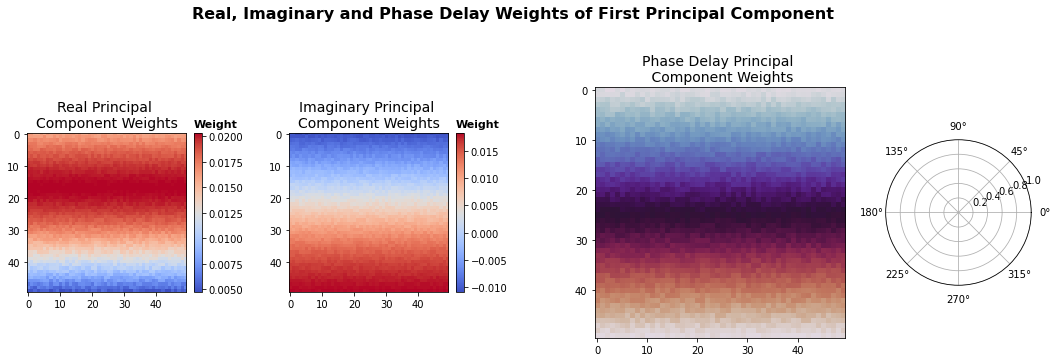

In [320]:


fig = plt.figure(figsize=(18,6))
fig.suptitle('Real, Imaginary and Phase Delay Weights of First Principal Component', fontsize=16, fontweight='bold')

gspec = fig.add_gridspec(1,2, wspace=0.3, width_ratios=[0.5, 0.5])
g_sub0 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gspec[0], wspace=0.5)
g_sub1 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gspec[1], wspace=0.1, width_ratios=[0.65,0.35])
ax0 = fig.add_subplot(g_sub0[0])
ax1 = fig.add_subplot(g_sub0[1])
ax2 = fig.add_subplot(g_sub1[0])
ax3 = fig.add_subplot(g_sub1[1], projection='polar')

im0 = ax0.imshow(real_weights.reshape(50,50), cmap='coolwarm')
im1 = ax1.imshow(imag_weights.reshape(50,50), cmap='coolwarm')
im2 = ax2.imshow(phase_weights.reshape(50,50), cmap='twilight')

ax0.set_title(f'Real Principal \nComponent Weights', fontsize=14)
ax1.set_title(f'Imaginary Principal \nComponent Weights', fontsize=14)
ax2.set_title(f'Phase Delay Principal \n Component Weights', fontsize=14)

divider0 = make_axes_locatable(ax0)
divider1 = make_axes_locatable(ax1)
divider2 = make_axes_locatable(ax2)
cax0 = divider0.append_axes("right", size="5%", pad=0.1)
cax1 = divider1.append_axes("right", size="5%", pad=0.1)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)
cax2.axis('off')
cbar0 = plt.colorbar(im0, cax=cax0)
cbar1 = plt.colorbar(im1, cax=cax1)
cbar0.ax.set_title("Weight", fontsize=11, loc='left', fontweight='bold')
cbar1.ax.set_title("Weight", fontsize=11, loc='left', fontweight='bold')

twilight_cmap = plt.get_cmap('twilight')
xval = np.arange(-0.3, 1.5, 0.001)
yval = np.ones_like(xval)
twilight_shifted = shiftedColorMap(twilight_cmap, midpoint=0.75)
norm = colors.Normalize(-0.3, 1.5)
ax3.scatter(xval, yval, c=xval, s=150, cmap=twilight_shifted, norm=norm, linewidths=0)
ax3.set_yticks([])
convert_polar_xticks_to_radians(ax3)
ax3.set_title("Phase \nDelay", fontsize=12, loc='center', fontweight='bold')
ax3.margins(x=0, y=-0.25) 
# plt.annotate('Direction of \nTime ', xy=(0.96, 0.5), xytext=(0.96,0.3),
#              xycoords='figure fraction',
#              textcoords='figure fraction', 
#              arrowprops=dict(facecolor='black', shrink=0.05),
#              ha='center'
#             )
ax3.annotate("",
            xy=(0.95,0.46),  
            xytext=(0.915, 0.62),    
            xycoords='figure fraction',
            textcoords='figure fraction',
            arrowprops=dict(facecolor='black', arrowstyle='<-', connectionstyle="angle3, angleA=0, angleB=90", alpha = 0.9, linewidth=3),
            fontsize=12,
            horizontalalignment='right',
            verticalalignment='top',
            bbox=dict(pad=5, facecolor="none", edgecolor="none")
)
ax3.text(0.9, 0.7, 'Direction of \n Time', transform=plt.gcf().transFigure, fontsize=12)

plt.savefig('results/figures/supplementaryC2_simulationPCA.png', bbox_inches='tight')
# plt.show()